# Synthetic neural benchmarking

- this notebook will demo how to use CEBRA, piVAE, tSNE and UMAP on synthetic datasets.

- Mac pre-M1, *Windows, and Ubuntu users can skip to cell 2.
- *This has not been tested on Windows

In [ ]:
#Attention: M1 chip users ONLY: 
# TF is a dependency of piVAE, which is used in this demo. 
# It requires a few extra steps that are addressed in this cell; in short, please run this once.
# See also: https://developer.apple.com/metal/tensorflow-plugin/ if any issues.

!pip uninstall -y tensorflow-deps tensorflow-macos tensorflow-metal keras

!conda install pytorch torchvision torchaudio -c pytorch
!pip install --upgrade --force-reinstall scikit-learn

!conda install -c apple -y tensorflow-deps==2.5.0 --force-reinstall
!python -m pip install tensorflow-macos
!python -m pip install tensorflow-metal

- Install note: be sure you have demo dependencies installed to use this notebook: 

In [ ]:
!pip install 'cebra[datasets,demos]'

In [1]:
#import packages:
import matplotlib.pyplot as plt
import numpy as np
import torch
import joblib as jl
import sklearn.linear_model
import openTSNE

In [2]:
import umap

/Users/mwmathis/miniforge3/envs/cebra_m1/lib/python3.9/site-packages/numba/cpython/hashing.py:524: UserWarning: FNV hashing is not implemented in Numba. See PEP 456 https://www.python.org/dev/peps/pep-0456/ for rationale over not using FNV. Numba will continue to work, but hashes for built in types will be computed using siphash24. This will permit e.g. dictionaries to continue to behave as expected, however anything relying on the value of the hash opposed to hash as a derived property is likely to not work as expected.
  warnings.warn(msg)


In [3]:
#import CEBRA:
from cebra import CEBRA
from cebra.datasets import get_datapath

In [4]:
#import piVAE:
import os
import sys
sys.path.insert(0, '../third_party')
import pivae.pivae_code.pi_vae as pivae
from keras.callbacks import ModelCheckpoint

- Be sure you have downloaded the data and placed `/data` from [FigShare](https://figshare.com/s/60adb075234c2cc51fa3) and into the `demo_notebooks` directory. Let's check if it's there:

In [1]:
ls

Demo_Allen.ipynb                      Demo_learnable_temperature.ipynb
Demo_cohomology.ipynb                 Demo_primate_reaching.ipynb
Demo_consistency.ipynb                Demo_primate_reaching_mse_loss.ipynb
Demo_conv-pivae.ipynb                 Demo_synthetic_exp.ipynb
Demo_decoding.ipynb                   README.rst
Demo_hippocampus.ipynb                data/
Demo_hippocampus_multisession.ipynb   rat_demo_example_output.h5
Demo_hypothesis_testing.ipynb


### Let's load the data:

(-3.411717481214122, 9.427972850408525, -4.042572592877058, 4.03572573445655)

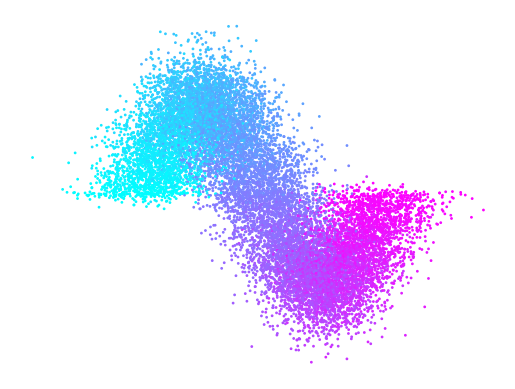

In [5]:
data = jl.load(get_datapath('synthetic/continuous_label_poisson.jl'))
plt.scatter(data['z'][:, 0], data['z'][:, 1], c=data['u'], s=1, cmap='cool')
plt.axis('off')

### Define the reconstruction score we use for all methods:

In [6]:
def reconstruction_score(x, y):

    def _linear_fitting(x, y):
        lin_model = sklearn.linear_model.LinearRegression()
        lin_model.fit(x, y)
        return lin_model.score(x, y), lin_model.predict(x)

    return _linear_fitting(x, y)

# CEBRA

- Define & fit a 🦓 <font color='blue'>C</font><font color='MediumSlateBlue'>E</font><font color='BlueViolet'>B</font><font color='MediumVioletRed'>R</font><font color='red'>A</font>  model:
- For a quick CPU run-time demo, you can drop `max_iterations` to 500; otherwise set to 10,000.

In [7]:
max_iterations = 5000

In [8]:
cebra_model = CEBRA(
    model_architecture="offset1-model-mse",
    batch_size=512,
    learning_rate=1e-4,
    max_iterations=max_iterations,
    delta=0.1,
    conditional='delta',
    output_dimension=2,
    distance='euclidean',
    device="cuda_if_available",
    verbose=True,
)

In [9]:
cebra_model.fit(data['x'][:12000], data['u'][:12000])

_continuous_index
_discrete_index
_seed
_seed


pos:  0.6078 neg:  4.5545 total:  5.1623: 100%|██████████████████████████████| 5000/5000 [01:50<00:00, 45.28it/s]


CEBRA(batch_size=512, conditional='delta', delta=0.1, distance='euclidean',
      learning_rate=0.0001, max_iterations=5000,
      model_architecture='offset1-model-mse', output_dimension=2, verbose=True)

linear reconstruction score: 0.9182325140113027


(-1.0815959811210631,
 8.637835347652436,
 -2.9030434846878053,
 2.9840209245681764)

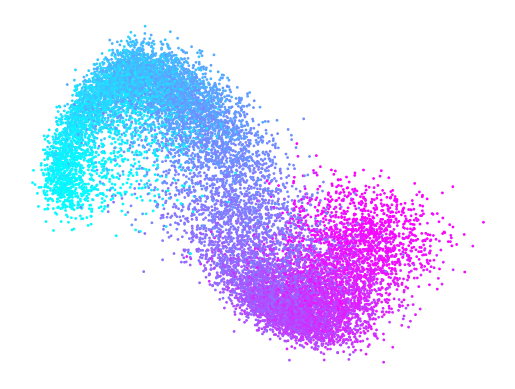

In [10]:
cebra_output = cebra_model.transform(data['x'])
cebra_score, transformed_cebra_z = reconstruction_score(cebra_output,
                                                        data['z'][:, :2])
print(f"linear reconstruction score: {cebra_score}")
plt.scatter(transformed_cebra_z[:, 0],
            transformed_cebra_z[:, 1],
            c=data['u'],
            s=1,
            cmap='cool')
plt.axis('off')

# t-SNE

In [11]:
tsne_model = openTSNE.TSNE(perplexity=84,
                           n_components=2,
                           initialization='pca',
                           random_state=None,
                           metric='euclidean')

In [12]:
tsne_model.fit(data['x'])
tsne_output = tsne_model.fit(data['x'])

linear reconstruction score: 0.7932575825931458


(-0.38784403902211856,
 7.009045915002804,
 -2.7633283196331018,
 2.5604785068064775)

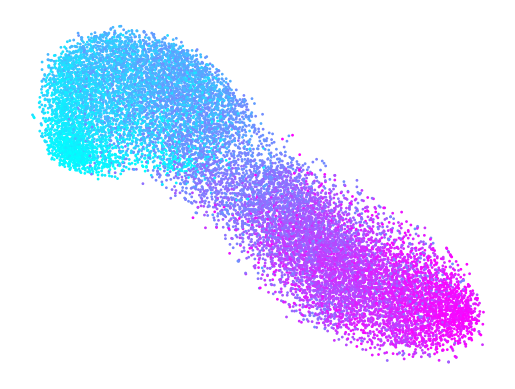

In [13]:
tsne_score, transformed_tsne_z = reconstruction_score(tsne_output,
                                                      data['z'][:, :2])
print(f"linear reconstruction score: {tsne_score}")
plt.scatter(transformed_tsne_z[:, 0],
            transformed_tsne_z[:, 1],
            c=data['u'],
            s=1,
            cmap='cool')
plt.axis('off')

# UMAP

In [14]:
umap_model = umap.UMAP(n_neighbors=68,
                       min_dist=0.2475,
                       n_components=2,
                       random_state=None,
                       metric='euclidean')
umap_output = umap_model.fit_transform(data['x'])

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


linear reconstruction score: 0.8285673979402988


(-0.4230464577674866, 6.97549067735672, -2.575450968742371, 2.7685633420944216)

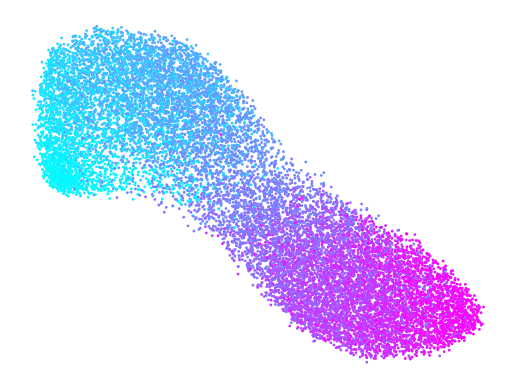

In [15]:
umap_score, transformed_umap_z = reconstruction_score(umap_output,
                                                      data['z'][:, :2])
print(f"linear reconstruction score: {umap_score}")
plt.scatter(transformed_umap_z[:, 0],
            transformed_umap_z[:, 1],
            c=data['u'],
            s=1,
            cmap='cool')
plt.axis('off')

# piVAE

The dataset parsing, model configuration and training are all adapted from https://github.com/zhd96/pi-vae/blob/main/examples/pi-vae_simulated_data_continuous_label.ipynb
- piVAE has a long run time. We store checkpoints.

In [16]:
u_true = data['u']
z_true = data['z']
x_true = data['x']
x_all = x_true.reshape(50, 300, -1)
u_all = u_true.reshape(50, 300, -1)

x_train = x_all[:40]
u_train = u_all[:40]
x_valid = x_all[40:]
u_valid = u_all[40:]
print(f'Train set has {len(x_train)} samples')

Train set has 40 samples


In [17]:
vae = pivae.vae_mdl(dim_x=x_all[0].shape[-1],
                    dim_z=2,
                    dim_u=u_all[0].shape[-1],
                    gen_nodes=60,
                    n_blk=2,
                    mdl='poisson',
                    disc=False,
                    learning_rate=5e-4)

Metal device set to: Apple M1 Pro


2022-09-20 19:46:30.664168: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-20 19:46:30.664281: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 encoder (Functional)           [(None, 2),          20228       ['input_1[0][0]',                
                                 (None, 2),                       'input_3[0][0]']                
                                 (None, 2),                                                       
                                 (None, 2),                                                     

/Users/mwmathis/miniforge3/envs/cebra_m1/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [18]:
model_chk_path = 'synthetic_pivae.h5'
mcp = ModelCheckpoint(model_chk_path,
                      monitor="val_loss",
                      save_best_only=True,
                      save_weights_only=True)
s_n = vae.fit_generator(pivae.custom_data_generator(x_train, u_train),
                        steps_per_epoch=len(x_train),
                        epochs=100,
                        verbose=0,
                        validation_data=pivae.custom_data_generator(
                            x_valid, u_valid),
                        validation_steps=len(x_valid),
                        callbacks=[mcp])

/var/folders/ct/4w_vk2wn10xb_xj2fm7d6vqc0000gn/T/ipykernel_17311/1414530926.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  s_n = vae.fit_generator(pivae.custom_data_generator(x_train, u_train),
2022-09-20 19:46:31.009258: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-20 19:46:31.716471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-09-20 19:46:33.174729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [19]:
vae.load_weights(model_chk_path)
outputs = vae.predict_generator(pivae.custom_data_generator(x_all, u_all),
                                steps=len(x_all))
#post_mean, post_log_var, z_sample,fire_rate, lam_mean, lam_log_var, z_mean, z_log_var
z_post = outputs[0]

/var/folders/ct/4w_vk2wn10xb_xj2fm7d6vqc0000gn/T/ipykernel_17311/323301550.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  outputs = vae.predict_generator(pivae.custom_data_generator(x_all, u_all),
2022-09-20 19:47:56.368218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


linear reconstruction score: 0.8170253307283855


(-1.922655415534973, 7.055900406837464, -2.461803549528122, 1.9950003564357757)

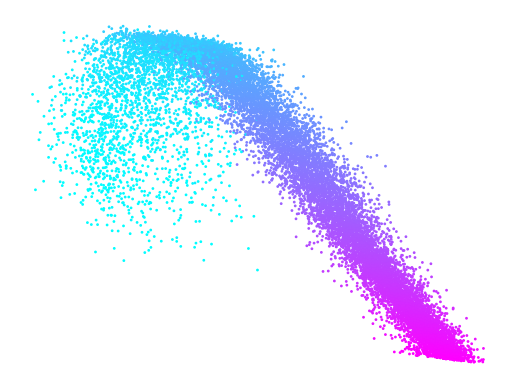

In [20]:
pivae_score, transformed_pivae_z = reconstruction_score(z_post,
                                                        data['z'][:, :2])
print(f"linear reconstruction score: {pivae_score}")
plt.scatter(transformed_pivae_z[:, 0],
            transformed_pivae_z[:, 1],
            c=data['u'],
            s=1,
            cmap='cool')
plt.axis('off')